# Part I: Imports

In [1]:
# Imports
import os
import requests
import pandas as pd
import numpy as np
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime
import seaborn as sns

%matplotlib inline

# Part II: API Data Extraction & Cleansing

In [2]:
# Setting path variable
path = ('/Users/jordanromnes/Downloads/Project_1/keys.env')

In [3]:
# Load .env environment variables
load_dotenv(path)

True

In [4]:
# Setting Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

In [5]:
# Creating the Alpaca API object
alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")

In [6]:
# Setting date range for API data extraction
start_date = pd.Timestamp('2021-01-01', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2024-01-01', tz='America/New_York').isoformat()

In [7]:
# Extracting 3 years worth(1/1/21:1/1/24) of historical data for each stock
timeframe = "1Day"
ticker = ['AAPL', 'JPM', 'META', 'UNP', 'XOM', 'NEE', 'UNH', 'RIO', 'EQIX', 'WMT', 'AMZN']
stocks_df = alpaca.get_bars(
    ticker,
    timeframe,
    start=start_date,
    end=end_date,
    limit=10000
).df

# Cleaning data so only closing stock prices are retrieved
AAPL = stocks_df[stocks_df['symbol']=='AAPL'].drop(['symbol', 'high', 'low', 'trade_count', 'open', 'volume', 'vwap'], axis=1)
JPM = stocks_df[stocks_df['symbol']=='JPM'].drop(['symbol', 'high', 'low', 'trade_count', 'open', 'volume', 'vwap'], axis=1)
META = stocks_df[stocks_df['symbol']=='META'].drop(['symbol', 'high', 'low', 'trade_count', 'open', 'volume', 'vwap'], axis=1)
UNP = stocks_df[stocks_df['symbol']=='UNP'].drop(['symbol', 'high', 'low', 'trade_count', 'open', 'volume', 'vwap'], axis=1)
XOM = stocks_df[stocks_df['symbol']=='XOM'].drop(['symbol', 'high', 'low', 'trade_count', 'open', 'volume', 'vwap'], axis=1)
NEE = stocks_df[stocks_df['symbol']=='NEE'].drop(['symbol', 'high', 'low', 'trade_count', 'open', 'volume', 'vwap'], axis=1)
UNH = stocks_df[stocks_df['symbol']=='UNH'].drop(['symbol', 'high', 'low', 'trade_count', 'open', 'volume', 'vwap'], axis=1)
RIO = stocks_df[stocks_df['symbol']=='RIO'].drop(['symbol', 'high', 'low', 'trade_count', 'open', 'volume', 'vwap'], axis=1)
EQIX = stocks_df[stocks_df['symbol']=='EQIX'].drop(['symbol', 'high', 'low', 'trade_count', 'open', 'volume', 'vwap'], axis=1)
WMT = stocks_df[stocks_df['symbol']=='WMT'].drop(['symbol', 'high', 'low', 'trade_count', 'open', 'volume', 'vwap'], axis=1)
AMZN = stocks_df[stocks_df['symbol']=='AMZN'].drop(['symbol', 'high', 'low', 'trade_count', 'open', 'volume', 'vwap'], axis=1)

# Concatenating the stock DataFrames, adding keys to represent each stock by ticker, renaming axis 'Date'
stocks_df = pd.concat([AAPL, JPM, META, UNP, XOM, NEE, UNH, RIO, EQIX, WMT, AMZN],axis=1, keys=['AAPL', 'JPM', 'META', 'UNP', 'XOM', 'NEE', 'UNH', 'RIO', 'EQIX', 'WMT', 'AMZN'])
stocks_df.rename_axis('Date', inplace=True)
# Display sample data
stocks_df.head()

AAPL     JPM    META     UNP    XOM    NEE  \
                            close   close   close   close  close  close   
Date                                                                      
2021-01-04 05:00:00+00:00  129.41  125.87  268.94  203.01  41.50  74.22   
2021-01-05 05:00:00+00:00  131.01  125.65  270.97  205.50  43.50  74.77   
2021-01-06 05:00:00+00:00  126.66  131.55  263.34  209.80  44.61  78.43   
2021-01-07 05:00:00+00:00  130.92  135.87  268.74  212.72  44.96  79.29   
2021-01-08 05:00:00+00:00  132.05  136.02  267.57  218.82  45.46  81.13   

                              UNH    RIO    EQIX     WMT     AMZN  
                            close  close   close   close    close  
Date                                                               
2021-01-04 05:00:00+00:00  349.50  77.39  692.56  146.53  3186.63  
2021-01-05 05:00:00+00:00  344.80  79.26  691.54  145.75  3218.51  
2021-01-06 05:00:00+00:00  359.27  82.80  668.96  146.66  3138.38  
2021-01-07 05:00:00+00:00  365.03  85.98  678.97  146.65  3162.16  
2021-01-08 05:00:00+00:00  363.39  86.69  692.46  146.63  3182.70

# Part III: Historical Analysis
Contains:

• Daily returns of all stocks composing portfolio. Each stock is representing a sector for the purpose of our experiment/analysis.

• Daily and cumulative returns of each weighted portfolio. Our control portfolio has all 11 stocks weighted evenly(0.09 each). We have 11 other portfolios with 10 stocks weighted evenly (0.075), while one stock is weighted (0.25). Each of the 11 non control portfolios has a different stock weighted more heavily to show the performance of each sector. 

• Historical values of each weighted portfolio. With a given investment of $20,000 at the start date of our historical data. We calculated the historical value of that initial investment today to compare how each "sector/portfolio" performed.

## All Stocks Historic Daily Returns

In [8]:
# Calculating all stocks daily returns
stock_daily_returns = stocks_df.pct_change()
# Dropping NAs
stock_daily_returns = stocks_df.pct_change().dropna()
stock_daily_returns.rename(columns={'close': 'Daily Returns'}, inplace=True)
# Showing sample data
stock_daily_returns.head()

AAPL           JPM          META  \
                          Daily Returns Daily Returns Daily Returns   
Date                                                                  
2021-01-05 05:00:00+00:00      0.012364     -0.001748      0.007548   
2021-01-06 05:00:00+00:00     -0.033204      0.046956     -0.028158   
2021-01-07 05:00:00+00:00      0.033633      0.032839      0.020506   
2021-01-08 05:00:00+00:00      0.008631      0.001104     -0.004354   
2021-01-11 05:00:00+00:00     -0.023249      0.014924     -0.040102   

                                    UNP           XOM           NEE  \
                          Daily Returns Daily Returns Daily Returns   
Date                                                                  
2021-01-05 05:00:00+00:00      0.012265      0.048193      0.007410   
2021-01-06 05:00:00+00:00      0.020925      0.025517      0.048950   
2021-01-07 05:00:00+00:00      0.013918      0.007846      0.010965   
2021-01-08 05:00:00+00:00      0.028676      0.011121      0.023206   
2021-01-11 05:00:00+00:00     -0.006718      0.030356     -0.017749   

                                    UNH           RIO          EQIX  \
                          Daily Returns Daily Returns Daily Returns   
Date                                                                  
2021-01-05 05:00:00+00:00     -0.013448      0.024163     -0.001473   
2021-01-06 05:00:00+00:00      0.041966      0.044663     -0.032652   
2021-01-07 05:00:00+00:00      0.016033      0.038406      0.014964   
2021-01-08 05:00:00+00:00     -0.004493      0.008258      0.019868   
2021-01-11 05:00:00+00:00     -0.007265     -0.033568     -0.014542   

                                    WMT          AMZN  
                          Daily Returns Daily Returns  
Date                                                   
2021-01-05 05:00:00+00:00     -0.005323      0.010004  
2021-01-06 05:00:00+00:00      0.006244     -0.024897  
2021-01-07 05:00:00+00:00     -0.000068      0.007577  
2021-01-08 05:00:00+00:00     -0.000136      0.006496  
2021-01-11 05:00:00+00:00      0.004501     -0.021519

## Calculations of all portfolios: daily returns, cumulative returns, & historic values

### Control Portfolio

In [9]:
# Setting initial investment of $20,000 for calculating the historical values of each portfolio if $20,000 was initially invested at the start of our data set.
initial_investment = 20000

In [10]:
# Setting Control Portfolio weights
control_weights = [0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09]

# Calculating Control Portfolio daily returns
control_daily_returns = stock_daily_returns.dot(control_weights)

# Calculating control portfolio cumulative returns
control_cumulative_returns = (1 + pd.Series(control_daily_returns)).cumprod()

# Calculating historical value of control portfolio with $20,000 invested at the start of dataframe to the value at the end of dataframe
control_historical_value = initial_investment * control_cumulative_returns

### Technology Portfolio

In [11]:
# Setting weights for Technology Portfolio
tech_weights = [0.25, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075]

# Calculate Technology portfolio return
tech_daily_returns = stock_daily_returns.dot(tech_weights)

# Calculating technology portfolio cumulative returns
tech_cumulative_returns = (1 + pd.Series(tech_daily_returns)).cumprod()

# Calculating historical value of technology portfolio with $20,000 invested at the start of dataframe to the value at the end of dataframe
tech_historical_value = initial_investment * tech_cumulative_returns

### Financial Portfolio

In [12]:
# Set weights for financial portfolio
fin_weights = [0.075, 0.25, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075]

# Calculate financial portfolio return
fin_daily_returns = stock_daily_returns.dot(fin_weights)

# Calculating financial cumulative returns
fin_cumulative_returns = (1 + pd.Series(fin_daily_returns)).cumprod()

# Calculating historical value of financial portfolio with $20,000 invested at the start of dataframe to the value at the end of dataframe
fin_historical_value = initial_investment * fin_cumulative_returns

### Consumer Services Portfolio

In [13]:
# Set weights for consumer services portfolio
con_ser_weights = [0.075, 0.075, 0.25, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075]

# Calculate portfolio return
con_ser_daily_returns = stock_daily_returns.dot(con_ser_weights)

# Calculating cumulative returns
con_ser_cumulative_returns = (1 + pd.Series(con_ser_daily_returns)).cumprod()

# Calculating historical value of consumer services portfolio with $20,000 invested at the start of dataframe to the value at the end of dataframe
con_ser_historical_value = initial_investment * con_ser_cumulative_returns

### Industrial Portfolio

In [14]:
# Set weights
ind_weights = [0.075, 0.075, 0.075, 0.25, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075]

# Calculate portfolio return
ind_daily_returns = stock_daily_returns.dot(ind_weights)

# Calculating cumulative returns
ind_cumulative_returns = (1 + pd.Series(ind_daily_returns)).cumprod()

# Calculating historical value of industrial portfolio with $20,000 invested at the start of dataframe to the value at the end of dataframeind_historical_value = initial_investment * ind_cumulative_returns
ind_historical_value = initial_investment * ind_cumulative_returns

### Energy Portfolio

In [15]:
# Set weights
nrg_weights = [0.075, 0.075, 0.075, 0.075, 0.25, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075]

# Calculate portfolio return
nrg_daily_returns = stock_daily_returns.dot(nrg_weights)

# Calculating cumulative returns
nrg_cumulative_returns = (1 + pd.Series(nrg_daily_returns)).cumprod()

# Calculating historical value of energy portfolio with $20,000 invested at the start of dataframe to the value at the end of dataframenrg_historical_value = initial_investment * nrg_cumulative_returns
nrg_historical_value = initial_investment * nrg_cumulative_returns

### Utilities Portfolio

In [16]:
# Set weights
util_weights = [0.075, 0.075, 0.075, 0.075, 0.075, 0.25, 0.075, 0.075, 0.075, 0.075, 0.075]

# Calculate portfolio return
util_daily_returns = stock_daily_returns.dot(util_weights)

# Calculating cumulative returns
util_cumulative_returns = (1 + pd.Series(util_daily_returns)).cumprod()

# Calculating historical value of utilities portfolio with $20,000 invested at the start of dataframe to the value at the end of dataframeutil_historical_value = initial_investment * util_cumulative_returns
util_historical_value = initial_investment * util_cumulative_returns

### Healthcare Portfolio

In [17]:
# Set weights
hc_weights = [0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.25, 0.075, 0.075, 0.075, 0.075]

# Calculate portfolio return
hc_daily_returns = stock_daily_returns.dot(hc_weights)

# Calculating cumulative returns
hc_cumulative_returns = (1 + pd.Series(hc_daily_returns)).cumprod()

# Calculating historical value of healthcare portfolio with $20,000 invested at the start of dataframe to the value at the end of dataframehc_historical_value = initial_investment * hc_cumulative_returns
hc_historical_value = initial_investment * hc_cumulative_returns

### Materials Portfolio

In [18]:
# Set weights
mat_weights = [0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.25, 0.075, 0.075, 0.075]

# Calculate portfolio return
mat_daily_returns = stock_daily_returns.dot(mat_weights)

# Calculating cumulative returns
mat_cumulative_returns = (1 + pd.Series(mat_daily_returns)).cumprod()

# Calculating historical value of materials portfolio with $20,000 invested at the start of dataframe to the value at the end of dataframemat_historical_value = initial_investment * mat_cumulative_returns
mat_historical_value = initial_investment * mat_cumulative_returns

### Real Estate Portfolio

In [19]:
# Set weights
re_weights = [0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.25, 0.075, 0.075]

# Calculate portfolio return
re_daily_returns = stock_daily_returns.dot(re_weights)

# Calculating cumulative returns
re_cumulative_returns = (1 + pd.Series(re_daily_returns)).cumprod()

# Calculating historical value of real estate portfolio with $20,000 invested at the start of dataframe to the value at the end of dataframere_historical_value = initial_investment * re_cumulative_returns
re_historical_value = initial_investment * re_cumulative_returns

### Consumer Staples Portfolio

In [20]:
# Set weights
con_staple_weights = [0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.25, 0.075]

# Calculate portfolio return
con_staple_daily_returns = stock_daily_returns.dot(con_staple_weights)

# Calculating cumulative returns
con_staple_cumulative_returns = (1 + pd.Series(con_staple_daily_returns)).cumprod()

# Calculating historical value of consumer staples portfolio with $20,000 invested at the start of dataframe to the value at the end of dataframecon_staple_historical_value = initial_investment * con_staple_cumulative_returns
con_staple_historical_value = initial_investment * con_staple_cumulative_returns

### Consumer Discretionary Portfolio

In [21]:
# Set weights
con_disc_weights = [0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.25]

# Calculate portfolio return
con_disc_daily_returns = stock_daily_returns.dot(con_disc_weights)

# Calculating cumulative returns
con_disc_cumulative_returns = (1 + pd.Series(con_disc_daily_returns)).cumprod()

# Calculating historical value of consumer discretionary portfolio with $20,000 invested at the start of dataframe to the value at the end of dataframecon_disc_historical_value = initial_investment * con_disc_cumulative_returns
con_disc_historical_value = initial_investment * con_disc_cumulative_returns

## Concatenation of all portfolio data

### Combining All Historic Values into a single DataFrame

In [22]:
all_historical_values_df = pd.concat([
    control_historical_value, 
    tech_historical_value,
    fin_historical_value,
    con_ser_historical_value,
    ind_historical_value,
    nrg_historical_value,
    util_historical_value,
    hc_historical_value,
    mat_historical_value,
    re_historical_value,
    con_staple_historical_value,
    con_disc_historical_value], keys=['Control', 'Technology', 'Finance', 'Consumer Services', 'Industrial', 'Energy', 'Utilities', 'Healthcare', 'Materials', 'Real Estate', 'Consumer Staples', 'Consumer Discretionary'], axis=1)

### Combining All Cumulative Returns into a single DataFrame

In [23]:
all_cumulative_returns_df = pd.concat([
    control_cumulative_returns, 
    tech_cumulative_returns,
    fin_cumulative_returns,
    con_ser_cumulative_returns,
    ind_cumulative_returns,
    nrg_cumulative_returns,
    util_cumulative_returns,
    hc_cumulative_returns,
    mat_cumulative_returns,
    re_cumulative_returns,
    con_staple_cumulative_returns,
    con_disc_cumulative_returns], keys=['Control', 'Technology', 'Finance', 'Consumer Services', 'Industrial', 'Energy', 'Utilities', 'Healthcare', 'Materials', 'Real Estate', 'Consumer Staples', 'Consumer Discretionary'], axis=1)

### Combining All Daily Returns into a single DataFrame

In [24]:
all_daily_returns_df = pd.concat([
    control_daily_returns, 
    tech_daily_returns,
    fin_daily_returns,
    con_ser_daily_returns,
    ind_daily_returns,
    nrg_daily_returns,
    util_daily_returns,
    hc_daily_returns,
    mat_daily_returns,
    re_daily_returns,
    con_staple_daily_returns,
    con_disc_daily_returns], keys=['Control', 'Technology', 'Finance', 'Consumer Services', 'Industrial', 'Energy', 'Utilities', 'Healthcare', 'Materials', 'Real Estate', 'Consumer Staples', 'Consumer Discretionary'], axis=1)

# Part IV: Risk Analysis

In [25]:
## Use all_returns_df for Risk Analysis
all_portfolio_std = all_daily_returns_df.std()
all_portfolio_std.sort_values()

Consumer Staples          0.010495
Healthcare                0.010574
Industrial                0.011045
Energy                    0.011160
Finance                   0.011163
Control                   0.011185
Utilities                 0.011202
Real Estate               0.011430
Materials                 0.011609
Technology                0.011724
Consumer Services         0.013237
Consumer Discretionary    0.014920
dtype: float64

In [26]:
## Determine which portfolios are riskier
volatility = all_daily_returns_df.std() * np.sqrt(252)
volatility.sort_values()

Consumer Staples          0.166595
Healthcare                0.167854
Industrial                0.175337
Energy                    0.177164
Finance                   0.177203
Control                   0.177557
Utilities                 0.177830
Real Estate               0.181447
Materials                 0.184282
Technology                0.186116
Consumer Services         0.210138
Consumer Discretionary    0.236854
dtype: float64

In [27]:
## Calculate the Annualized Standard Deviation.
annualized_std = all_daily_returns_df.std() * np.sqrt(252)
annualized_std.sort_values()

Consumer Staples          0.166595
Healthcare                0.167854
Industrial                0.175337
Energy                    0.177164
Finance                   0.177203
Control                   0.177557
Utilities                 0.177830
Real Estate               0.181447
Materials                 0.184282
Technology                0.186116
Consumer Services         0.210138
Consumer Discretionary    0.236854
dtype: float64

# Part V: Monte Carlo 5 year simulation with an initial investment of $20,000 for each portfolio

## Control Portfolio

In [28]:
# Configuring a Monte Carlo simulation to forecast 5 years cumulative returns
MC_5_year_control = MCSimulation(
    portfolio_data = stocks_df,
    weights = [0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09],
    num_simulation = 500,
    num_trading_days = 252*5
)

In [29]:
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
MC_5_year_control.calc_cumulative_return()

0         0         0         0         0         0         0  \
0     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1     1.007489  0.999621  1.001441  0.999972  1.004891  0.990258  1.004597   
2     0.991242  0.999668  1.001176  0.996857  1.006535  0.984646  0.998939   
3     0.990211  1.002261  0.995270  1.007235  1.017421  0.983946  1.009543   
4     0.991998  1.007310  0.996232  1.013749  1.026831  0.975564  1.009050   
...        ...       ...       ...       ...       ...       ...       ...   
1256  1.338348  1.780292  1.570921  2.228521  1.605474  0.898196  1.504627   
1257  1.331186  1.754010  1.549788  2.249634  1.604016  0.908035  1.514602   
1258  1.317315  1.759496  1.549219  2.234240  1.609067  0.915560  1.510218   
1259  1.331454  1.743616  1.520927  2.211641  1.616214  0.907910  1.505110   
1260  1.336993  1.736287  1.512772  2.203272  1.615997  0.912044  1.524976   

             0         0         0  ...         0         0         0  \
0     1.000000  1.000000  1.000000  ...  1.000000  1.000000  1.000000   
1     1.001300  1.004018  0.998016  ...  0.998734  1.000695  0.998233   
2     1.011179  1.002646  0.997332  ...  0.992602  1.003812  1.003587   
3     0.997708  0.995261  1.001620  ...  0.992746  1.001246  1.008359   
4     0.997079  0.998587  1.003723  ...  0.996120  1.004440  1.000623   
...        ...       ...       ...  ...       ...       ...       ...   
1256  1.965769  1.232818  1.966499  ...  2.095503  0.945726  1.460199   
1257  1.960884  1.237090  1.964950  ...  2.085510  0.957136  1.457340   
1258  1.956351  1.227487  1.952100  ...  2.085960  0.955577  1.452720   
1259  1.950308  1.223941  1.970133  ...  2.118012  0.956640  1.441356   
1260  1.956392  1.220383  1.964768  ...  2.119362  0.959606  1.441849   

             0         0         0         0         0         0         0  
0     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  
1     1.002564  1.000668  1.000831  0.996874  1.005038  0.997582  1.003634  
2     0.991382  1.002055  1.010077  1.005887  1.012751  0.994211  1.010328  
3     0.992603  1.005949  1.009531  1.008327  1.001169  0.993225  1.018200  
4     0.999440  1.011169  1.012655  1.009064  0.996729  0.982420  1.008548  
...        ...       ...       ...       ...       ...       ...       ...  
1256  1.737534  1.036441  0.986743  1.522501  1.172640  2.108778  2.041993  
1257  1.755380  1.043421  0.981724  1.539504  1.156363  2.106625  2.047706  
1258  1.768596  1.050734  0.975560  1.539934  1.155184  2.108382  2.054140  
1259  1.763160  1.051480  0.974856  1.536400  1.161869  2.094452  2.033868  
1260  1.754291  1.037008  0.980395  1.522162  1.163566  2.108265  2.061372  

[1261 rows x 500 columns]

In [30]:
# Fetch summary statistics from the Monte Carlo simulation results
five_year_summary_control = MC_5_year_control.summarize_cumulative_return()

## Technology Portfolio

In [31]:
MC_5_year_tech = MCSimulation(
    portfolio_data = stocks_df,
    weights = [0.25, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075],
    num_simulation = 500,
    num_trading_days = 252*5
)

In [32]:
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
MC_5_year_tech.calc_cumulative_return()

0         0         0         0         0         0         0  \
0     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1     0.997034  0.999502  0.987107  0.991852  0.993897  1.011943  0.996700   
2     0.992421  1.000672  0.967229  0.989705  1.004822  1.007238  1.008570   
3     0.983323  1.007774  0.976765  0.996480  0.990193  1.012637  0.989754   
4     0.984309  1.007824  0.984708  0.989007  0.973550  1.013065  0.984265   
...        ...       ...       ...       ...       ...       ...       ...   
1256  1.379309  1.309483  0.996277  1.208449  1.569963  2.012880  1.110774   
1257  1.368000  1.317233  1.000759  1.201016  1.568787  2.031875  1.123432   
1258  1.356571  1.314445  0.994250  1.194116  1.555676  2.040768  1.125589   
1259  1.337686  1.312922  1.000147  1.176364  1.567180  2.059332  1.121516   
1260  1.339489  1.325116  1.013716  1.182642  1.563698  2.048904  1.127636   

             0         0         0  ...         0         0         0  \
0     1.000000  1.000000  1.000000  ...  1.000000  1.000000  1.000000   
1     1.008615  1.001747  1.011024  ...  1.003039  0.991549  0.999799   
2     1.012529  1.003403  1.005151  ...  1.013624  1.004300  1.000536   
3     1.012499  1.004587  0.995435  ...  1.017888  1.004506  1.002980   
4     1.016020  1.013217  0.994604  ...  1.023828  1.000973  1.002976   
...        ...       ...       ...  ...       ...       ...       ...   
1256  1.945707  1.487792  1.363448  ...  1.699515  1.819282  1.651980   
1257  1.953217  1.488307  1.363000  ...  1.702481  1.836300  1.640106   
1258  1.963857  1.501568  1.352596  ...  1.723951  1.831213  1.645357   
1259  1.960507  1.503770  1.343827  ...  1.703066  1.825496  1.667621   
1260  1.939557  1.528786  1.354914  ...  1.696041  1.834528  1.684102   

             0         0         0         0         0         0         0  
0     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  
1     1.002921  1.003694  1.005192  1.006595  0.996285  1.006962  1.002824  
2     0.996476  1.013610  0.995826  1.018665  0.998453  1.007146  0.994084  
3     0.997298  1.009870  1.003419  1.026616  0.985295  1.031089  0.982942  
4     1.000168  1.014888  1.009271  1.018805  0.995026  1.033879  0.988602  
...        ...       ...       ...       ...       ...       ...       ...  
1256  1.878548  1.423666  1.803247  1.152772  2.292072  2.183259  2.290897  
1257  1.870353  1.413848  1.815827  1.147016  2.318671  2.194950  2.278513  
1258  1.884247  1.428772  1.811250  1.147211  2.312651  2.222803  2.259574  
1259  1.863917  1.437065  1.821082  1.143654  2.312004  2.224027  2.254975  
1260  1.853368  1.455124  1.805647  1.137982  2.312583  2.251127  2.240956  

[1261 rows x 500 columns]

In [33]:
# Fetch summary statistics from the Monte Carlo simulation results
five_year_summary_tech = MC_5_year_tech.summarize_cumulative_return()

## Financial Portfolio

In [34]:
MC_5_year_fin = MCSimulation(
    portfolio_data = stocks_df,
    weights = [0.075, 0.25, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075],
    num_simulation = 500,
    num_trading_days = 252*5
)

In [35]:
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
MC_5_year_fin.calc_cumulative_return()

0         0         0         0         0         0         0  \
0     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1     1.005513  1.002466  0.997332  0.996276  1.004943  0.992281  0.991441   
2     1.006910  0.992961  0.998544  1.002353  1.004714  0.995439  0.980870   
3     1.017544  0.999752  1.008145  0.994190  0.991276  0.991854  0.969941   
4     1.031547  0.992238  1.002964  0.994593  0.987220  1.008249  0.966008   
...        ...       ...       ...       ...       ...       ...       ...   
1256  1.596854  1.494319  1.394050  1.508380  0.927447  1.879849  1.660601   
1257  1.598230  1.527741  1.394580  1.520753  0.932894  1.893675  1.646239   
1258  1.594158  1.522891  1.398002  1.515591  0.924516  1.888077  1.638225   
1259  1.583823  1.507234  1.395043  1.524711  0.921974  1.895725  1.640773   
1260  1.577471  1.493172  1.399884  1.536002  0.907974  1.874911  1.645561   

             0         0         0  ...         0         0         0  \
0     1.000000  1.000000  1.000000  ...  1.000000  1.000000  1.000000   
1     1.005516  1.003670  0.995635  ...  1.006863  1.002210  0.990731   
2     1.003466  1.004307  0.998566  ...  1.002111  1.007996  0.997501   
3     0.999960  1.003700  0.991359  ...  1.003140  1.018457  1.005387   
4     1.001519  1.008710  0.986859  ...  0.998863  1.019100  0.998049   
...        ...       ...       ...  ...       ...       ...       ...   
1256  2.602561  1.427545  1.966087  ...  2.106629  1.564242  2.649203   
1257  2.618001  1.431058  1.979177  ...  2.134574  1.562352  2.648444   
1258  2.626517  1.423434  1.999852  ...  2.106343  1.545913  2.634717   
1259  2.639229  1.412555  1.994553  ...  2.105050  1.539096  2.621580   
1260  2.632310  1.417432  1.972831  ...  2.099131  1.527922  2.623742   

             0         0         0         0         0         0         0  
0     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  
1     0.998598  1.003250  0.994482  1.001830  1.007841  0.999538  0.996840  
2     0.998917  0.992634  0.996194  1.008040  1.013047  0.999305  0.991642  
3     1.005142  0.994019  0.989358  1.013770  1.006273  1.006394  0.982502  
4     0.997096  0.986683  0.993943  1.004645  1.011921  1.010886  0.978132  
...        ...       ...       ...       ...       ...       ...       ...  
1256  1.889849  1.407377  1.418868  1.657840  1.349016  1.162646  1.444518  
1257  1.895834  1.398323  1.415980  1.664330  1.348595  1.166053  1.444755  
1258  1.886667  1.379098  1.418638  1.668142  1.349363  1.177911  1.446347  
1259  1.894899  1.369357  1.411453  1.682943  1.358654  1.176678  1.453294  
1260  1.920951  1.367711  1.416920  1.676443  1.351213  1.172619  1.461542  

[1261 rows x 500 columns]

In [36]:
# Fetch summary statistics from the Monte Carlo simulation results
five_year_summary_fin = MC_5_year_fin.summarize_cumulative_return()

## Consumer Services Portfolio

In [37]:
MC_5_year_con_ser = MCSimulation(
    portfolio_data = stocks_df,
    weights = [0.075, 0.075, 0.25, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075],
    num_simulation = 500,
    num_trading_days = 252*5
)

In [38]:
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
MC_5_year_con_ser.calc_cumulative_return()

0         0         0         0         0         0         0  \
0     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1     1.016025  1.010136  1.011766  0.999443  1.015408  1.002154  1.007970   
2     1.026571  1.012587  1.016130  1.002419  1.018701  0.997911  1.018109   
3     1.033197  1.017862  1.009406  0.990462  1.017525  0.991533  1.010393   
4     1.024377  1.026389  1.012928  0.996957  1.004126  0.996272  1.028823   
...        ...       ...       ...       ...       ...       ...       ...   
1256  0.938819  1.753009  1.947793  2.935900  2.787008  1.585152  2.312187   
1257  0.958428  1.755407  1.963495  2.941165  2.802389  1.583466  2.275434   
1258  0.953221  1.768182  1.969409  2.949669  2.773699  1.588467  2.281165   
1259  0.949593  1.789539  1.934656  2.971311  2.777272  1.602749  2.271920   
1260  0.930352  1.814321  1.975822  2.952391  2.734276  1.598297  2.249024   

             0         0         0  ...         0         0         0  \
0     1.000000  1.000000  1.000000  ...  1.000000  1.000000  1.000000   
1     1.012757  1.017962  0.997563  ...  0.993044  1.010918  1.004336   
2     1.014123  1.020454  0.990385  ...  0.990930  1.012829  1.008432   
3     1.014158  1.028516  0.978952  ...  0.987158  1.024940  1.013978   
4     1.017678  1.034037  0.983476  ...  0.993318  1.019773  1.021144   
...        ...       ...       ...  ...       ...       ...       ...   
1256  1.380712  1.542387  1.093658  ...  0.826660  1.609591  2.222349   
1257  1.388184  1.549004  1.080302  ...  0.814063  1.615260  2.225530   
1258  1.381102  1.553329  1.077528  ...  0.815554  1.619741  2.261580   
1259  1.371459  1.557150  1.085454  ...  0.808216  1.615523  2.252330   
1260  1.374923  1.559471  1.095297  ...  0.809542  1.613255  2.253883   

             0         0         0         0         0         0         0  
0     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  
1     1.009467  0.994611  0.995371  0.994363  1.005199  1.005991  0.996148  
2     1.006319  1.000323  1.010420  0.993571  1.022433  1.006206  0.983345  
3     1.001328  1.014795  1.002768  0.986881  1.016823  1.005523  0.986803  
4     0.992400  1.017251  1.015155  0.984457  1.008295  0.985870  1.009166  
...        ...       ...       ...       ...       ...       ...       ...  
1256  1.542432  1.353038  1.940548  1.472655  2.367195  1.294227  1.498491  
1257  1.541081  1.353313  1.941014  1.465682  2.354682  1.308891  1.501906  
1258  1.559398  1.343805  1.940497  1.459067  2.355149  1.309091  1.477922  
1259  1.553589  1.337789  1.963316  1.448376  2.345900  1.299118  1.478655  
1260  1.558038  1.346740  1.952136  1.441275  2.320478  1.296206  1.477545  

[1261 rows x 500 columns]

In [39]:
# Fetch summary statistics from the Monte Carlo simulation results
five_year_summary_con_ser = MC_5_year_con_ser.summarize_cumulative_return()

## Industrial Portfolio

In [40]:
MC_5_year_ind= MCSimulation(
    portfolio_data = stocks_df,
    weights = [0.075, 0.075, 0.075, 0.25, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075],
    num_simulation = 500,
    num_trading_days = 252*5
)

In [41]:
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
MC_5_year_ind.calc_cumulative_return()

0         0         0         0         0         0         0  \
0     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1     1.004090  0.994886  0.996183  1.002804  0.999580  1.003897  1.001171   
2     1.015226  0.999308  0.978581  0.992895  1.004727  1.009622  0.994637   
3     1.021134  1.010654  0.971494  0.982040  1.004610  1.017998  0.991819   
4     1.016391  1.008337  0.984235  0.970056  1.007366  1.023924  0.990013   
...        ...       ...       ...       ...       ...       ...       ...   
1256  1.775403  1.341528  1.876356  1.829902  1.654387  1.372393  1.437036   
1257  1.758084  1.344881  1.877407  1.818432  1.642066  1.362574  1.423389   
1258  1.754223  1.353855  1.884107  1.798401  1.646142  1.361637  1.424923   
1259  1.743049  1.361489  1.896490  1.799275  1.654486  1.372149  1.408109   
1260  1.733419  1.368834  1.892048  1.785145  1.658186  1.395820  1.413651   

             0         0         0  ...         0         0         0  \
0     1.000000  1.000000  1.000000  ...  1.000000  1.000000  1.000000   
1     1.002934  1.007680  0.994879  ...  0.998072  1.004086  1.001566   
2     1.002889  0.993215  0.983478  ...  0.987669  1.011112  0.997493   
3     1.008949  0.991786  0.978190  ...  0.986826  1.017552  1.004399   
4     1.018849  0.992235  0.972639  ...  0.990644  1.014594  1.004387   
...        ...       ...       ...  ...       ...       ...       ...   
1256  1.741713  1.357971  2.236246  ...  1.680215  1.572790  1.641510   
1257  1.738413  1.344384  2.247981  ...  1.678439  1.574383  1.642361   
1258  1.771244  1.334784  2.243274  ...  1.672453  1.574601  1.631207   
1259  1.763450  1.336262  2.239507  ...  1.677247  1.582487  1.625506   
1260  1.763923  1.356456  2.221832  ...  1.683162  1.557845  1.606426   

             0         0         0         0         0         0         0  
0     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  
1     0.999262  1.008046  1.008855  0.995691  0.999444  1.001009  0.996815  
2     1.003271  1.009041  1.017507  1.005100  1.001369  1.007574  1.000059  
3     1.005799  1.007499  1.016234  0.991074  1.002709  0.998297  0.999034  
4     0.990581  1.012574  1.014719  0.991778  0.998274  0.999424  1.008205  
...        ...       ...       ...       ...       ...       ...       ...  
1256  1.034630  1.830868  1.150324  1.350353  1.036831  2.001982  1.908534  
1257  1.033345  1.842161  1.154065  1.357145  1.036537  2.006033  1.914488  
1258  1.030850  1.828183  1.156097  1.363627  1.034889  2.019078  1.930241  
1259  1.034395  1.830769  1.155257  1.363262  1.035351  2.030261  1.937633  
1260  1.030021  1.830621  1.142386  1.375940  1.027575  2.052444  1.947817  

[1261 rows x 500 columns]

In [42]:
# Fetch summary statistics from the Monte Carlo simulation results
five_year_summary_ind = MC_5_year_ind.summarize_cumulative_return()

## Energy Portfolio

In [43]:
MC_5_year_nrg = MCSimulation(
    portfolio_data = stocks_df,
    weights = [0.075, 0.075, 0.075, 0.075, 0.25, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075],
    num_simulation = 500,
    num_trading_days = 252*5
)

In [44]:
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
MC_5_year_nrg.calc_cumulative_return()

0         0         0         0         0         0         0  \
0     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1     0.990499  0.997158  1.000836  0.993198  1.001677  0.996942  0.999001   
2     0.988234  0.984138  1.004368  0.992187  0.997335  0.998243  1.011612   
3     0.994323  0.979791  1.010266  1.004964  1.006342  0.987768  1.029049   
4     0.981981  0.980051  1.002885  1.001921  1.006028  0.999654  1.025308   
...        ...       ...       ...       ...       ...       ...       ...   
1256  1.912196  1.444079  2.084389  1.600563  2.624208  1.456108  2.039044   
1257  1.895966  1.438701  2.113764  1.589140  2.621393  1.440445  2.071754   
1258  1.901058  1.426979  2.116403  1.611405  2.599483  1.439162  2.088505   
1259  1.914134  1.424502  2.107337  1.609366  2.602118  1.432850  2.077819   
1260  1.929693  1.410485  2.098733  1.605685  2.598495  1.423759  2.110052   

             0         0         0  ...         0         0         0  \
0     1.000000  1.000000  1.000000  ...  1.000000  1.000000  1.000000   
1     1.005752  0.999500  0.997144  ...  1.006194  0.991060  1.021566   
2     0.996697  1.002579  1.000671  ...  1.010693  0.988783  1.032616   
3     0.995546  0.994140  0.989460  ...  1.009743  1.006639  1.036054   
4     0.994217  0.997528  0.978931  ...  1.005055  1.009153  1.025885   
...        ...       ...       ...  ...       ...       ...       ...   
1256  1.612373  2.526532  1.553350  ...  2.153389  2.825173  2.047590   
1257  1.613153  2.536609  1.565848  ...  2.172363  2.806181  2.033581   
1258  1.628899  2.528225  1.571663  ...  2.154476  2.810121  2.054081   
1259  1.628206  2.519536  1.569465  ...  2.135150  2.799820  2.076497   
1260  1.628975  2.549894  1.578257  ...  2.143599  2.807746  2.079329   

             0         0         0         0         0         0         0  
0     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  
1     1.001684  0.994396  1.001283  0.998925  0.984590  1.001023  1.008669  
2     1.002963  0.999775  0.993350  1.001111  0.963626  1.008784  1.005651  
3     0.994255  0.995762  0.984982  0.998907  0.973995  1.010106  1.009719  
4     0.983980  0.991127  0.985237  1.008181  0.969717  1.024705  1.000927  
...        ...       ...       ...       ...       ...       ...       ...  
1256  1.118961  2.443927  1.834906  2.655713  0.965716  1.597541  1.877730  
1257  1.138035  2.440685  1.838199  2.676332  0.977565  1.581936  1.891766  
1258  1.136768  2.442710  1.859280  2.657722  0.984865  1.597273  1.897991  
1259  1.143769  2.429856  1.852129  2.656385  0.984108  1.605641  1.899768  
1260  1.140570  2.435777  1.867227  2.684368  1.001356  1.609758  1.892694  

[1261 rows x 500 columns]

In [45]:
# Fetch summary statistics from the Monte Carlo simulation results
five_year_summary_nrg = MC_5_year_nrg.summarize_cumulative_return()

## Utilities Portfolio

In [46]:
MC_5_year_util = MCSimulation(
    portfolio_data = stocks_df,
    weights = [0.075, 0.075, 0.075, 0.075, 0.075, 0.25, 0.075, 0.075, 0.075, 0.075, 0.075],
    num_simulation = 500,
    num_trading_days = 252*5
)

In [47]:
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
MC_5_year_util.calc_cumulative_return()

0         0         0         0         0         0         0  \
0     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1     0.989804  1.011045  0.992788  1.000365  0.989712  0.999483  0.985251   
2     0.975775  1.006055  0.987310  1.005119  0.999502  0.989042  0.974052   
3     0.969516  1.007576  0.992626  1.015589  0.988077  0.982086  0.978455   
4     0.971939  1.001278  0.998181  1.014408  0.986626  0.987336  0.975780   
...        ...       ...       ...       ...       ...       ...       ...   
1256  1.423351  1.453504  1.314423  1.153048  1.165037  1.111642  1.491291   
1257  1.416830  1.447901  1.304385  1.151093  1.178368  1.111886  1.496602   
1258  1.434255  1.444137  1.302791  1.158259  1.177191  1.107469  1.493307   
1259  1.429862  1.451231  1.310100  1.158157  1.171734  1.120963  1.497780   
1260  1.449674  1.451400  1.317264  1.147100  1.168638  1.117917  1.491004   

             0         0         0  ...         0         0         0  \
0     1.000000  1.000000  1.000000  ...  1.000000  1.000000  1.000000   
1     1.004805  0.988820  0.996173  ...  1.002990  1.005037  1.004547   
2     1.012504  0.995370  0.994766  ...  1.006445  0.996213  1.005412   
3     1.010661  0.983869  0.983677  ...  1.015800  0.995676  0.998552   
4     1.004588  0.986680  0.980144  ...  1.005684  0.993305  1.009252   
...        ...       ...       ...  ...       ...       ...       ...   
1256  1.846812  1.705747  1.228676  ...  1.330861  1.340029  1.501746   
1257  1.841944  1.710792  1.225926  ...  1.322016  1.335888  1.504741   
1258  1.839872  1.688545  1.245233  ...  1.323340  1.321621  1.497057   
1259  1.862994  1.688305  1.246582  ...  1.341999  1.312520  1.505747   
1260  1.861683  1.686101  1.249287  ...  1.339658  1.306496  1.502226   

             0         0         0         0         0         0         0  
0     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  
1     1.002231  0.997863  1.009300  0.998050  1.004948  1.000667  0.993822  
2     1.005754  1.008114  1.009096  0.992256  0.996971  0.994815  0.984655  
3     1.004344  1.012857  1.012787  0.989150  0.991899  0.995986  0.976945  
4     0.999134  1.032618  1.002470  0.986667  0.989253  1.002169  0.976985  
...        ...       ...       ...       ...       ...       ...       ...  
1256  1.383867  1.088470  1.532747  1.410888  1.731943  1.823782  1.447947  
1257  1.374441  1.080069  1.547284  1.397656  1.748807  1.831911  1.446953  
1258  1.379683  1.074756  1.541612  1.404393  1.741277  1.826868  1.440539  
1259  1.378168  1.079582  1.544093  1.418180  1.754647  1.828522  1.436185  
1260  1.386380  1.089027  1.561749  1.419304  1.737274  1.838180  1.445111  

[1261 rows x 500 columns]

In [48]:
# Fetch summary statistics from the Monte Carlo simulation results
five_year_summary_util = MC_5_year_util.summarize_cumulative_return()

## Healthcare Portfolio

In [49]:
MC_5_year_hc = MCSimulation(
    portfolio_data = stocks_df,
    weights = [0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.25, 0.075, 0.075, 0.075, 0.075],
    num_simulation = 500,
    num_trading_days = 252*5
)

In [50]:
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
MC_5_year_hc.calc_cumulative_return()

0         0         0         0         0         0         0  \
0     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1     1.000063  0.998482  0.995564  0.998995  1.008933  0.990250  1.009932   
2     0.993199  0.999816  0.999998  1.001797  1.012749  0.989955  1.007089   
3     0.986582  0.994282  1.009062  1.004663  1.011403  0.988040  1.014035   
4     0.985435  1.000108  1.012156  0.994470  1.022633  0.994652  1.005072   
...        ...       ...       ...       ...       ...       ...       ...   
1256  1.755402  1.429678  1.687442  1.535413  1.862306  1.675183  2.073709   
1257  1.761402  1.429549  1.694878  1.551105  1.854096  1.673402  2.076002   
1258  1.771921  1.411509  1.692752  1.559594  1.861944  1.681031  2.077917   
1259  1.762950  1.413118  1.686303  1.577118  1.880617  1.673713  2.068203   
1260  1.778697  1.416991  1.692431  1.579861  1.896503  1.683271  2.051382   

             0         0         0  ...         0         0         0  \
0     1.000000  1.000000  1.000000  ...  1.000000  1.000000  1.000000   
1     0.992748  0.997599  1.003603  ...  0.995565  0.997217  1.004926   
2     1.001963  0.994253  1.012877  ...  0.998627  1.000882  1.001098   
3     1.005607  0.991871  1.007503  ...  0.997592  0.994232  1.002624   
4     1.010860  0.991823  1.002615  ...  0.996798  0.984785  1.007194   
...        ...       ...       ...  ...       ...       ...       ...   
1256  2.393050  1.109002  1.471649  ...  1.995408  1.579887  1.537073   
1257  2.375192  1.119034  1.476464  ...  2.007283  1.579653  1.529207   
1258  2.375490  1.112266  1.484850  ...  2.019912  1.587095  1.530855   
1259  2.401352  1.108562  1.486479  ...  2.032187  1.587355  1.528467   
1260  2.398668  1.106336  1.484403  ...  2.022878  1.592987  1.532332   

             0         0         0         0         0         0         0  
0     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  
1     0.988814  1.005612  0.984754  0.994062  1.005235  1.004768  1.008516  
2     0.979413  1.008248  0.986117  0.999861  0.999656  1.021937  0.997981  
3     0.977882  1.018326  0.988203  1.007797  0.996190  1.026600  1.006964  
4     0.983192  1.019102  0.991146  1.015146  1.003483  1.041877  1.011342  
...        ...       ...       ...       ...       ...       ...       ...  
1256  1.827295  1.658502  1.112381  1.538952  1.661464  1.874347  1.071457  
1257  1.812509  1.654446  1.118159  1.532059  1.655382  1.860095  1.082677  
1258  1.820074  1.652177  1.121780  1.531968  1.652674  1.870426  1.081553  
1259  1.839718  1.657110  1.114698  1.513681  1.652028  1.864991  1.064628  
1260  1.841937  1.653762  1.113771  1.524750  1.639526  1.889832  1.067643  

[1261 rows x 500 columns]

In [51]:
# Fetch summary statistics from the Monte Carlo simulation results
five_year_summary_hc = MC_5_year_hc.summarize_cumulative_return()


## Materials Portfolio

In [52]:
MC_5_year_mat = MCSimulation(
    portfolio_data = stocks_df,
    weights = [0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.25, 0.075, 0.075, 0.075],
    num_simulation = 500,
    num_trading_days = 252*5
)

In [53]:
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
MC_5_year_mat.calc_cumulative_return()

0         0         0         0         0         0         0  \
0     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1     1.001712  0.993152  0.998805  1.007418  1.002584  0.993821  0.989129   
2     1.008182  0.991817  0.992879  1.009690  1.005060  0.983318  0.976069   
3     1.018761  0.993675  0.991701  1.010753  1.012380  0.980769  0.971403   
4     0.998191  0.988018  0.992214  1.009890  1.018970  0.983882  0.958155   
...        ...       ...       ...       ...       ...       ...       ...   
1256  2.024929  1.613903  1.934610  1.712062  1.466372  1.599211  1.458933   
1257  2.049961  1.604955  1.953732  1.731052  1.458068  1.593441  1.477907   
1258  2.023495  1.604441  1.958796  1.708608  1.455812  1.604798  1.494486   
1259  2.029574  1.609903  1.955141  1.714380  1.445443  1.620140  1.512385   
1260  2.027557  1.595234  1.934117  1.733154  1.448358  1.621460  1.515992   

             0         0         0  ...         0         0         0  \
0     1.000000  1.000000  1.000000  ...  1.000000  1.000000  1.000000   
1     1.009189  1.004578  1.005132  ...  1.004658  0.983722  1.003613   
2     1.011546  0.997544  1.004614  ...  1.010828  0.977320  1.004401   
3     1.014598  0.992189  1.009448  ...  1.013164  0.982967  1.014801   
4     1.016987  1.001016  1.010203  ...  1.016185  0.981240  1.006117   
...        ...       ...       ...  ...       ...       ...       ...   
1256  1.235546  1.705957  1.160886  ...  1.502402  1.229443  2.182996   
1257  1.212701  1.708046  1.160571  ...  1.514816  1.225507  2.177033   
1258  1.230639  1.727740  1.159747  ...  1.519288  1.237335  2.179874   
1259  1.228259  1.720813  1.160540  ...  1.523480  1.254752  2.170405   
1260  1.230719  1.716461  1.155625  ...  1.521809  1.251302  2.169664   

             0         0         0         0         0         0         0  
0     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  
1     0.998921  1.010339  0.991199  1.013622  1.008418  1.006901  1.000698  
2     0.993122  1.002415  0.989139  1.010111  1.005905  1.002096  0.992843  
3     0.999006  0.993841  0.978955  1.012937  1.005659  1.000349  0.989967  
4     0.998195  1.000163  0.992044  1.015735  1.004404  0.996380  1.001406  
...        ...       ...       ...       ...       ...       ...       ...  
1256  1.343469  1.225702  1.787860  1.106917  1.775347  1.679118  1.785491  
1257  1.328346  1.231360  1.805977  1.110382  1.789565  1.680458  1.791208  
1258  1.333626  1.244364  1.804844  1.110141  1.793899  1.679355  1.770963  
1259  1.341346  1.256359  1.806046  1.100263  1.797433  1.679612  1.756955  
1260  1.342935  1.256198  1.818566  1.102780  1.798153  1.674647  1.756856  

[1261 rows x 500 columns]

In [54]:
# Fetch summary statistics from the Monte Carlo simulation results
five_year_summary_mat = MC_5_year_mat.summarize_cumulative_return()

## Real Estate Portfolio

In [55]:
MC_5_year_re = MCSimulation(
    portfolio_data = stocks_df,
    weights = [0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.25, 0.075, 0.075],
    num_simulation = 500,
    num_trading_days = 252*5
)


In [56]:
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
MC_5_year_re.calc_cumulative_return()

0         0         0         0         0         0         0  \
0     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1     1.004580  0.999465  1.008687  1.003207  0.996278  0.998197  0.996427   
2     0.999588  0.997533  1.010642  0.999792  0.993716  0.986830  0.996019   
3     1.013821  0.997422  1.011909  1.001575  0.997135  0.987549  0.996785   
4     1.013670  1.004985  1.013489  1.000168  0.993071  0.993941  0.990976   
...        ...       ...       ...       ...       ...       ...       ...   
1256  1.405697  1.390361  1.716164  1.342276  2.915800  1.186404  1.526921   
1257  1.417427  1.381257  1.712420  1.328524  2.896425  1.194827  1.517256   
1258  1.414456  1.367828  1.700606  1.330080  2.903080  1.200301  1.532027   
1259  1.412325  1.383379  1.697221  1.329525  2.884100  1.207207  1.545581   
1260  1.404592  1.386231  1.703148  1.343358  2.873554  1.205413  1.545667   

             0         0         0  ...         0         0         0  \
0     1.000000  1.000000  1.000000  ...  1.000000  1.000000  1.000000   
1     1.000301  0.996458  0.995865  ...  1.002927  0.998806  0.991966   
2     1.000608  0.990705  1.005776  ...  1.020482  1.000046  1.003561   
3     1.001320  0.985372  1.000647  ...  1.011343  0.994784  0.990709   
4     1.003966  0.991807  0.995206  ...  1.002197  0.990788  0.988187   
...        ...       ...       ...  ...       ...       ...       ...   
1256  1.595365  1.817241  1.364257  ...  1.945692  1.854598  1.111758   
1257  1.591865  1.823550  1.376483  ...  1.965498  1.852065  1.108212   
1258  1.592703  1.839877  1.382492  ...  1.980430  1.834700  1.114112   
1259  1.602768  1.854538  1.372606  ...  1.979448  1.838088  1.129803   
1260  1.604261  1.855707  1.368815  ...  1.987387  1.849029  1.121608   

             0         0         0         0         0         0         0  
0     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  
1     0.992007  0.988606  0.997355  1.004360  1.002195  0.986360  1.007697  
2     0.997649  1.007367  0.978070  1.001940  0.993693  0.996437  1.004928  
3     1.005613  1.012047  0.969512  1.002625  1.004675  0.997579  1.004055  
4     1.016433  1.010520  0.974270  1.003652  1.000743  1.002579  1.007528  
...        ...       ...       ...       ...       ...       ...       ...  
1256  1.601198  2.131697  2.260917  2.025177  1.094337  1.505059  1.332916  
1257  1.596903  2.154042  2.245087  2.041174  1.106619  1.517897  1.325681  
1258  1.601584  2.176412  2.229931  2.030725  1.107762  1.512399  1.326671  
1259  1.604965  2.194554  2.219338  2.025347  1.110441  1.501553  1.327963  
1260  1.615491  2.204840  2.218986  2.019169  1.111153  1.510416  1.324226  

[1261 rows x 500 columns]

In [57]:
# Fetch summary statistics from the Monte Carlo simulation results
five_year_summary_re = MC_5_year_re.summarize_cumulative_return()

## Consumer Staples Portfolio

In [58]:
MC_5_year_con_staple = MCSimulation(
    portfolio_data = stocks_df,
    weights = [0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.25, 0.075],
    num_simulation = 500,
    num_trading_days = 252*5
)

In [59]:
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
MC_5_year_con_staple.calc_cumulative_return()

0         0         0         0         0         0         0  \
0     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1     1.011683  0.996265  1.004015  1.003922  1.002001  1.002574  1.004400   
2     1.012418  0.997520  1.016094  1.012547  0.997783  0.995417  1.011681   
3     1.009186  1.001681  1.013511  1.020683  1.006317  0.994800  1.000001   
4     1.009649  0.998944  1.022270  1.023633  1.010712  0.998551  0.999790   
...        ...       ...       ...       ...       ...       ...       ...   
1256  1.641605  1.807862  1.430546  1.493463  1.165324  1.644177  1.471820   
1257  1.632639  1.810127  1.416271  1.501949  1.158487  1.638816  1.477352   
1258  1.608334  1.828469  1.419424  1.504141  1.167557  1.654620  1.483877   
1259  1.588946  1.827795  1.423032  1.498949  1.168393  1.665938  1.485341   
1260  1.575947  1.814725  1.431701  1.499236  1.173463  1.677118  1.463482   

             0         0         0  ...         0         0         0  \
0     1.000000  1.000000  1.000000  ...  1.000000  1.000000  1.000000   
1     1.004129  1.000688  0.994701  ...  0.997187  1.012955  1.000305   
2     1.003145  1.003967  0.984559  ...  1.001956  1.013555  0.998539   
3     1.007061  1.003835  0.993368  ...  1.000753  1.018300  0.996655   
4     1.003925  1.004728  0.988222  ...  0.993002  1.024219  0.998766   
...        ...       ...       ...  ...       ...       ...       ...   
1256  1.945745  1.121610  1.437801  ...  1.104664  1.311538  1.100695   
1257  1.957976  1.133551  1.444879  ...  1.099982  1.313910  1.097374   
1258  1.944480  1.145923  1.445806  ...  1.109088  1.302637  1.102794   
1259  1.951055  1.142371  1.453973  ...  1.105990  1.298497  1.105724   
1260  1.974116  1.143027  1.439261  ...  1.115128  1.300513  1.110310   

             0         0         0         0         0         0         0  
0     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  
1     1.004754  0.995759  1.003772  0.993527  0.996313  1.002521  1.000170  
2     0.996115  0.997809  1.005374  0.994497  1.012633  1.002024  1.002199  
3     1.004848  0.995697  1.011345  0.992369  1.012318  1.011744  1.009966  
4     1.004514  0.995012  1.018985  0.996930  1.014269  1.020756  1.016964  
...        ...       ...       ...       ...       ...       ...       ...  
1256  1.396870  1.295127  1.520927  1.601365  1.925321  1.342510  1.391429  
1257  1.397092  1.279673  1.513024  1.610694  1.936790  1.340665  1.395303  
1258  1.402681  1.273276  1.509065  1.592977  1.921230  1.349944  1.404939  
1259  1.406313  1.275636  1.502013  1.578484  1.906630  1.372451  1.399021  
1260  1.396334  1.283553  1.496729  1.570446  1.923657  1.387673  1.397299  

[1261 rows x 500 columns]

In [60]:
# Fetch summary statistics from the Monte Carlo simulation results
five_year_summary_con_staple = MC_5_year_con_staple.summarize_cumulative_return()

## Consumer Discretionary Portfolio

In [61]:
MC_5_year_con_disc = MCSimulation(
    portfolio_data = stocks_df,
    weights = [0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.25, 0.075, 0.25],
    num_simulation = 500,
    num_trading_days = 252*5
)

In [62]:
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
MC_5_year_con_disc.calc_cumulative_return()

0         0         0         0         0         0         0  \
0     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1     1.009243  0.997338  1.010639  0.986593  1.014415  1.009056  0.996236   
2     1.033928  0.967701  1.011673  0.989969  1.022833  1.002205  0.980314   
3     1.033237  0.966446  1.005490  1.015057  1.024820  1.015503  0.992698   
4     1.042174  0.973683  1.010404  0.990537  1.024664  1.004736  0.995835   
...        ...       ...       ...       ...       ...       ...       ...   
1256  0.691249  1.007545  0.466377  0.880572  0.919400  0.892042  2.069325   
1257  0.672947  0.994699  0.458247  0.891771  0.905257  0.872654  2.059109   
1258  0.675519  1.002631  0.458087  0.875946  0.895870  0.876457  2.049177   
1259  0.680028  0.996293  0.466136  0.875733  0.901343  0.871362  2.038256   
1260  0.685088  0.987995  0.464520  0.868384  0.898818  0.857071  2.027232   

             0         0         0  ...         0         0         0  \
0     1.000000  1.000000  1.000000  ...  1.000000  1.000000  1.000000   
1     1.005189  0.987869  1.007826  ...  1.000884  0.977649  0.978734   
2     1.022545  1.000943  1.010577  ...  0.985333  0.973191  0.989450   
3     1.023179  0.994012  1.007357  ...  0.973236  0.984559  0.993968   
4     1.040936  0.986751  1.002147  ...  0.978536  0.970274  1.002235   
...        ...       ...       ...  ...       ...       ...       ...   
1256  0.916676  0.793819  1.670714  ...  1.558449  0.188774  1.571867   
1257  0.919920  0.804169  1.720272  ...  1.529565  0.192553  1.590021   
1258  0.909677  0.805264  1.747804  ...  1.573106  0.190958  1.562531   
1259  0.906708  0.811396  1.752706  ...  1.560827  0.189614  1.580330   
1260  0.915344  0.817161  1.766221  ...  1.539660  0.187823  1.563050   

             0         0         0         0         0         0         0  
0     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  
1     1.003767  0.967632  0.979882  0.990130  1.001843  1.017397  1.017809  
2     1.013265  0.963644  0.975105  0.991948  1.006599  1.017866  1.033762  
3     1.005323  0.961358  0.958844  0.991405  1.025744  1.020566  1.043393  
4     0.988527  0.948113  0.957109  0.985554  1.027812  1.044203  1.020551  
...        ...       ...       ...       ...       ...       ...       ...  
1256  1.466818  1.031238  1.551510  0.656934  0.825757  2.115449  1.370392  
1257  1.460916  1.038887  1.539497  0.665724  0.821729  2.148683  1.378982  
1258  1.464404  1.052077  1.580505  0.660984  0.811224  2.131316  1.388882  
1259  1.465557  1.062994  1.560952  0.647642  0.809659  2.121885  1.361769  
1260  1.462134  1.064419  1.591290  0.645662  0.801283  2.087055  1.351281  

[1261 rows x 500 columns]

In [63]:
# Fetch summary statistics from the Monte Carlo simulation results
five_year_summary_con_disc = MC_5_year_con_disc.summarize_cumulative_return()

# Part VI: Plots/Visualizations

## Dataframe created comprised of all portfolio weights

In [87]:
control_weights = [0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09]
tech_weights = [0.25, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075]
fin_weights = [0.075, 0.25, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075]
con_ser_weights = [0.075, 0.075, 0.25, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075]
ind_weights = [0.075, 0.075, 0.075, 0.25, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075]
nrg_weights = [0.075, 0.075, 0.075, 0.075, 0.25, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075]
util_weights = [0.075, 0.075, 0.075, 0.075, 0.075, 0.25, 0.075, 0.075, 0.075, 0.075, 0.075]
hc_weights = [0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.25, 0.075, 0.075, 0.075, 0.075]
mat_weights = [0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.25, 0.075, 0.075, 0.075]
re_weights = [0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.25, 0.075, 0.075]
con_staple_weights = [0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.25, 0.075]
con_disc_weights = [0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.25]
stocks = ['AAPL', 'JPM', 'META', 'UNP', 'XOM', 'NEE', 'UNH', 'RIO', 'EQIX', 'WMT', 'AMZN']
weights_df = pd.DataFrame({
    'Stock Ticker': stocks,
    'Control Portfolio Weights': control_weights,
    'Technology Portfolio Weights': tech_weights, 
    'Financial Portfolio Weights': fin_weights, 
    'Consumer Services Portfolio Weights': con_ser_weights, 
    'Industrial Portfolio Weights': ind_weights, 
    'Energy Portfolio Weights': nrg_weights, 
    'Utilities Portfolio Weights': util_weights,
    'Healthcare Portfolio Weights': hc_weights,
    'Materials Portfolio Weights': mat_weights, 
    'Real Estate Portfolio Weights': re_weights, 
    'Consumer Staples Portfolio Weights': con_staple_weights, 
    'Consumer Discretionary Portfolio Weights': con_disc_weights,
})

weights_df.set_index('Stock Ticker', inplace=True)
weights_df.head()


Control Portfolio Weights  Technology Portfolio Weights  \
Stock Ticker                                                            
AAPL                               0.09                         0.250   
JPM                                0.09                         0.075   
META                               0.09                         0.075   
UNP                                0.09                         0.075   
XOM                                0.09                         0.075   

              Financial Portfolio Weights  \
Stock Ticker                                
AAPL                                0.075   
JPM                                 0.250   
META                                0.075   
UNP                                 0.075   
XOM                                 0.075   

              Consumer Services Portfolio Weights  \
Stock Ticker                                        
AAPL                                        0.075   
JPM                                         0.075   
META                                        0.250   
UNP                                         0.075   
XOM                                         0.075   

              Industrial Portfolio Weights  Energy Portfolio Weights  \
Stock Ticker                                                           
AAPL                                 0.075                     0.075   
JPM                                  0.075                     0.075   
META                                 0.075                     0.075   
UNP                                  0.250                     0.075   
XOM                                  0.075                     0.250   

              Utilities Portfolio Weights  Healthcare Portfolio Weights  \
Stock Ticker                                                              
AAPL                                0.075                         0.075   
JPM                                 0.075                         0.075   
META                                0.075                         0.075   
UNP                                 0.075                         0.075   
XOM                                 0.075                         0.075   

              Materials Portfolio Weights  Real Estate Portfolio Weights  \
Stock Ticker                                                               
AAPL                                0.075                          0.075   
JPM                                 0.075                          0.075   
META                                0.075                          0.075   
UNP                                 0.075                          0.075   
XOM                                 0.075                          0.075   

              Consumer Staples Portfolio Weights  \
Stock Ticker                                       
AAPL                                       0.075   
JPM                                        0.075   
META                                       0.075   
UNP                                        0.075   
XOM                                        0.075   

              Consumer Discretionary Portfolio Weights  
Stock Ticker                                            
AAPL                                             0.075  
JPM                                              0.075  
META                                             0.075  
UNP                                              0.075  
XOM                                              0.075

## Dataframe created with all summary statistics of each portfolio from the Monte Carlo Simulation

In [89]:
#summary statistics data from MC summary stats
summary_data = {
    'Portfolio': ['Control Portfolio', 'Technology Portfolio', 'Financial Portfolio', 'Consumer Services Portfolio', 'Industrial Portfolio', 'Energy Portfolio', 'Utilities Portfolio', 'Healthcare Portfolio', 'Materials Portfolio', 'Real Estate Portfolio', 'Consumer Staples Portfolio', 'Consumer Discretionary Portfolio'],
    'Count': [500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500],
    'Mean': [1.545391, 1.659857, 1.615429, 1.740296, 1.578976, 1.952880, 1.427392, 1.672034, 1.499294, 1.544857, 1.523139, 1.255082],
    'Std': [0.358682, 0.372502, 0.367757, 0.543870, 0.365985, 0.469835, 0.334997, 0.394731, 0.387952, 0.378868, 0.340528, 0.550978],
    'Min': [0.703196, 0.870358, 0.664177, 0.752176, 0.788292, 0.776112, 0.502422, 0.832961, 0.726631, 0.746463, 0.787898, 0.377275],
    '25%': [1.277155, 1.391495, 1.339905, 1.353373, 1.311028, 1.607052, 1.191671, 1.391577, 1.205730, 1.261457, 1.282223, 0.859306],
    '50%': [1.505098, 1.621650, 1.574458, 1.640123, 1.548915, 1.894041, 1.390096, 1.622487, 1.452233, 1.502943, 1.475149, 1.154307],
    '75%': [1.773814, 1.892591, 1.832107, 2.091901, 1.808063, 2.217046, 1.624966, 1.891133, 1.722245, 1.763815, 1.712802, 1.563726],
    'Max': [3.242164, 2.958406, 3.257708, 4.233898, 2.950851, 3.666983, 2.805759, 3.104243, 3.211989, 3.529010, 3.012248, 3.989297],
    '95% CI Lower': [0.978377, 1.039767, 1.039084, 0.948574, 0.982911, 1.214852, 0.887621, 0.991597, 0.915699, 0.954109, 0.983309, 0.479429],
    '95% CI Upper': [2.296405, 2.450768, 2.495551, 2.986681, 2.390296, 2.997150, 2.169756, 2.582875, 2.345870, 2.403055, 2.349423, 2.602098],
}

# Create DataFrame
all_mc_summary_stats = pd.DataFrame(summary_data)

## Bar Chart to display portfolio weights

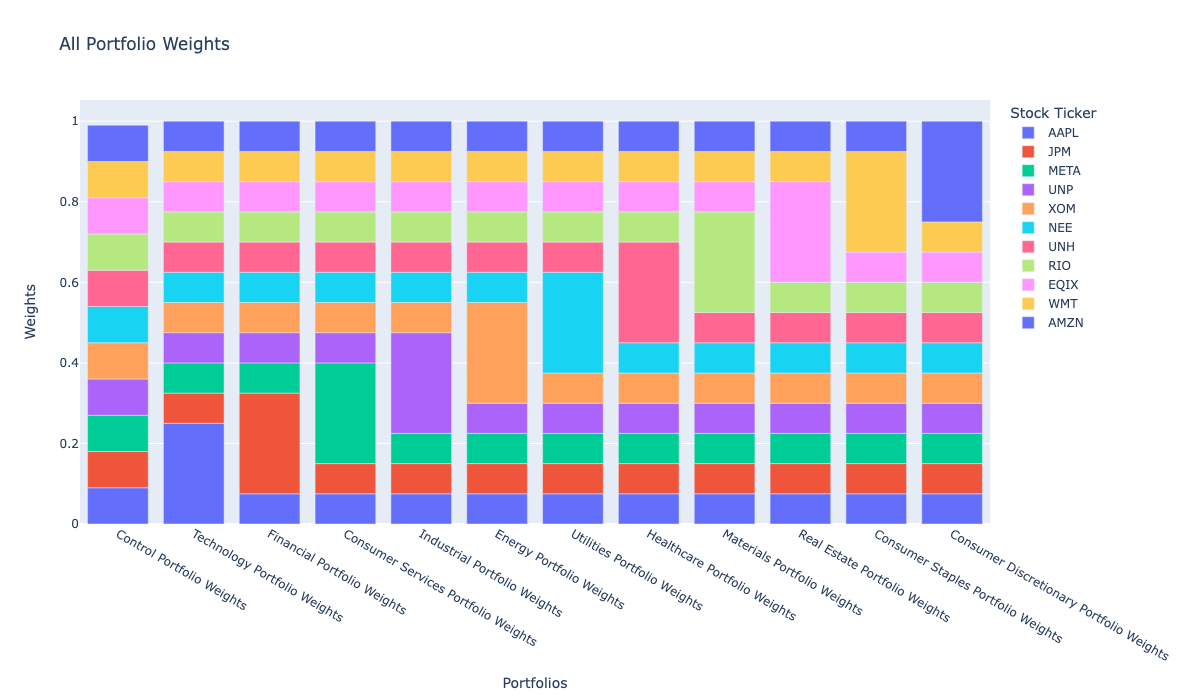

In [90]:
weights_df_fig = px.bar(weights_df.transpose(), labels={'value': 'Weights', 'index':'Portfolios'}, title='All Portfolio Weights', width=900, height=700)
weights_df_fig.show()

## Historic 3 year Cumulative Returns

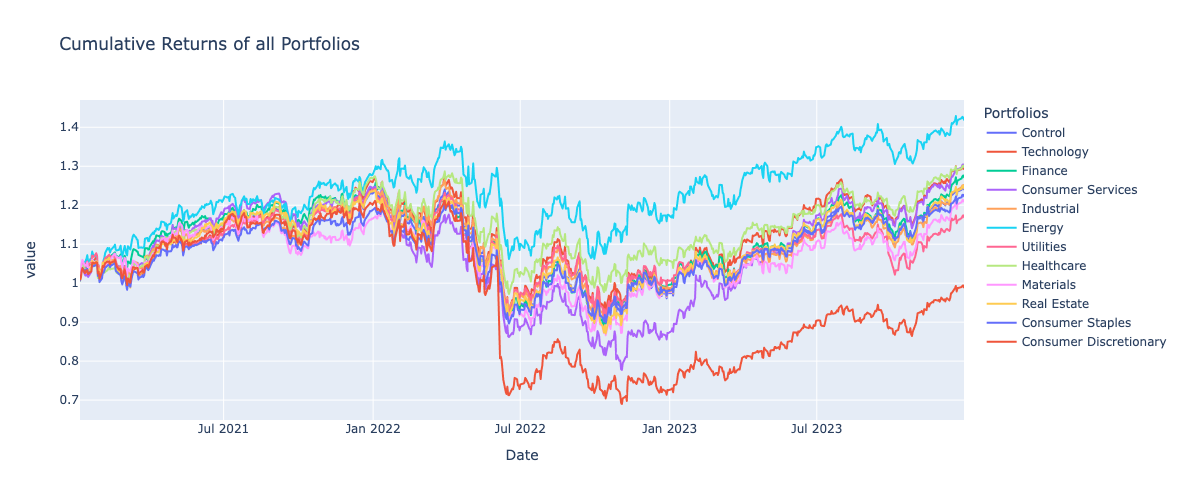

In [93]:
hist_cumulative_returns_fig = px.line(all_cumulative_returns_df, width=800, height=500, title="Cumulative Returns of all Portfolios", labels={ 'variable': 'Portfolios'})
hist_cumulative_returns_fig.show()

## Portfolios Historic Values with an Initial Investment of $20,000 at start of data

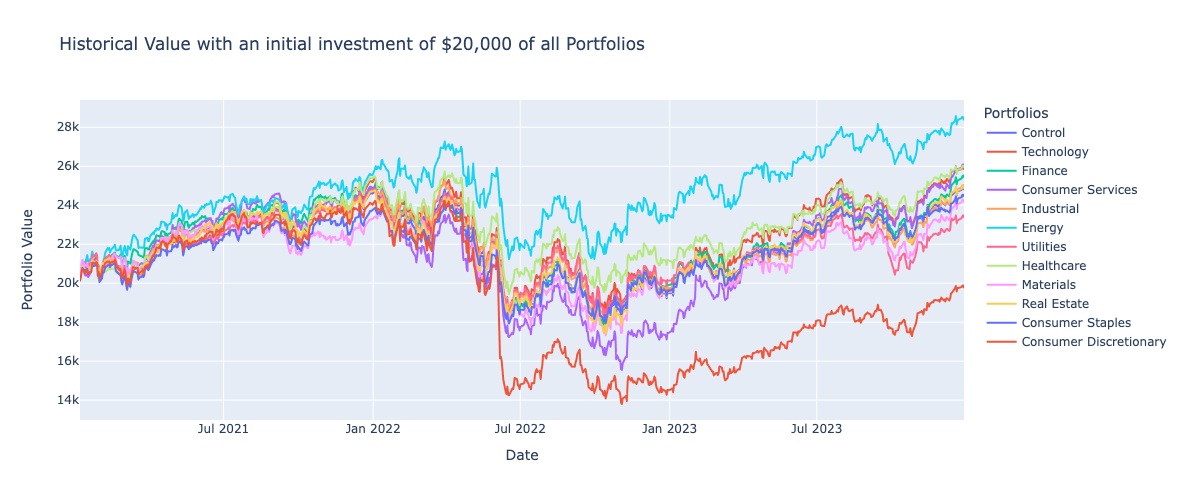

In [94]:
historical_values_fig = px.line(all_historical_values_df, width=800, height=500, title="Historical Value with an initial investment of $20,000 of all Portfolios", labels={ 'value': 'Portfolio Value',  'variable': 'Portfolios'})
historical_values_fig.show()

## Historic 3 year Daily Returns

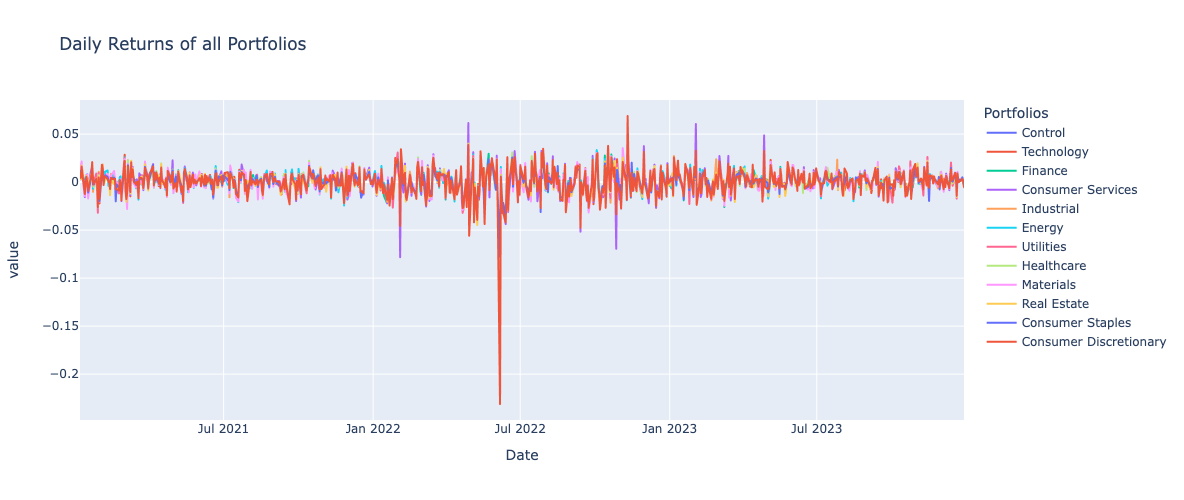

In [95]:
hist_daily_returns_fig = px.line(all_daily_returns_df, width=800, height=500, title="Daily Returns of all Portfolios", labels={ 'variable': 'Portfolios'})
hist_daily_returns_fig.show()

## Box plot for risk created with Historic 3 year Cumulative Returns

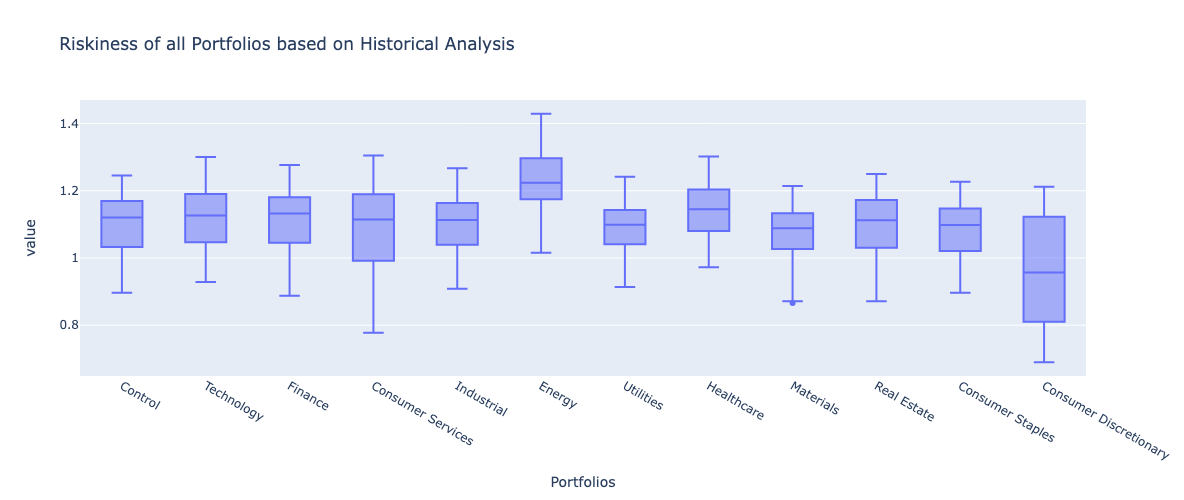

In [96]:
hist_risk_fig = px.box(all_cumulative_returns_df, width=800, height=500, title='Riskiness of all Portfolios based on Historical Analysis', labels={ 'variable': 'Portfolios'})
hist_risk_fig.show()

## Box plot for Potential Portfolio Values from 5 Year Monte Carlo Simulation with an initial investment of $20,000

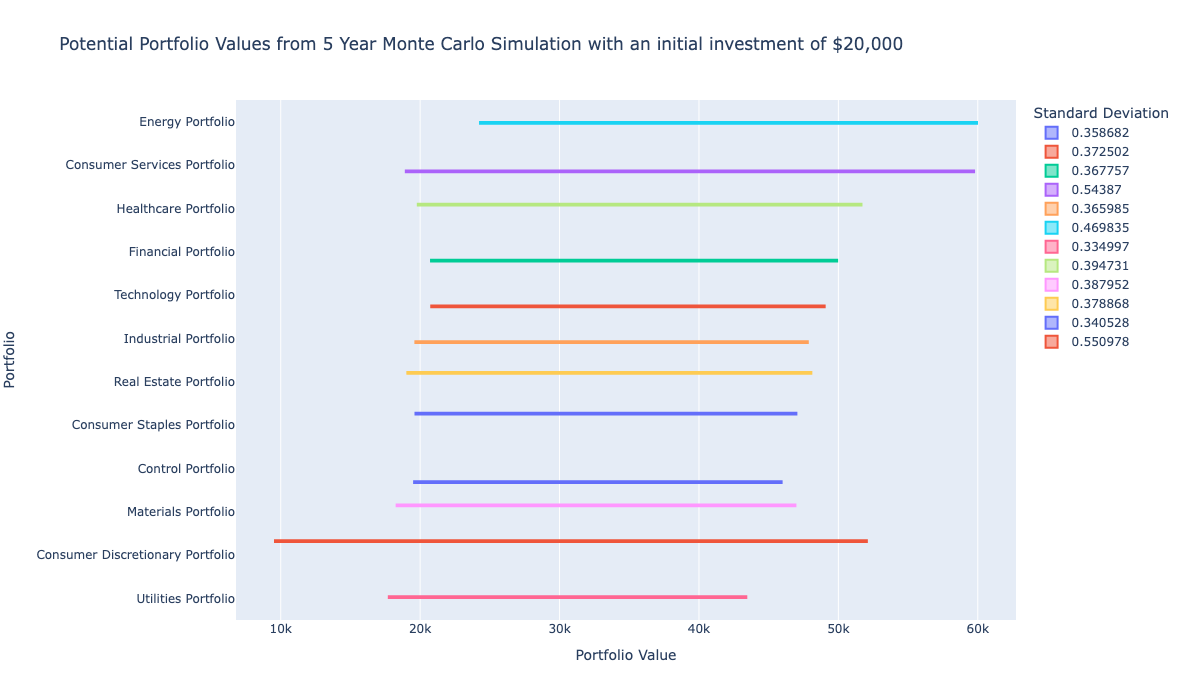

In [97]:
initial_investment = 20000

# Multiply the x-values by the initial investment
all_mc_summary_stats['95% CI Lower'] *= initial_investment
all_mc_summary_stats['95% CI Upper'] *= initial_investment

# Create a box plot
mc_risk_fig = px.box(
    all_mc_summary_stats,
    x=['95% CI Lower', '95% CI Upper'],
    y='Portfolio',
    color='Std',
    title='Potential Portfolio Values from 5 Year Monte Carlo Simulation with an initial investment of $20,000',
    labels={'value': 'Portfolio Value', 'variable': 'CI Bound', 'standard_deviation': 'Standard Deviation', 'portfolio': 'Portfolios'},
    width=900, 
    height=700
)

# Sort the box plot by standard deviation
mc_risk_fig.update_layout(
    yaxis=dict(categoryorder='total ascending'),  # Sort by standard deviation in ascending order
    legend=dict(title='Standard Deviation', traceorder='normal')  # Sort the legend by standard deviation
)


# Show the plot
mc_risk_fig.show()